In [1]:
import scipy.io as sio
import numpy as np
import trafpy.generator as tpg

In [2]:
# 1) .mat에서 그래프 불러오기
mat = sio.loadmat('graph_topologies_only.mat')
graph_k4_add = mat['graph_k4_add']          # (64, 64, 2, 8, 4)

# 예시: loop=0, del_per index=0, pa index=0 하나만 사용
A = graph_k4_add[:, :, 0, 0, 0].astype(float)
num_eps = A.shape[0]

# TrafPy는 토폴로지를 꼭 알아야 하진 않아서,
# 여기서는 "endpoint 리스트 + 용량"만 쓰고,
# A는 나중에 네트워크 시뮬레이터 쪽에서 쓰면 됨.
eps = [f'server_{i}' for i in range(num_eps)]

In [3]:
# Flow size (Bytes)
flow_size_dist = tpg.gen_named_val_dist(
    dist='lognormal',
    params={'_mu': 7.0, '_sigma': 2.5},
    show_fig=False,
    print_data=False,
    num_bins=10000,
)

# 확인
print(type(flow_size_dist))
print("sum probs =", sum(flow_size_dist.values()))
print("some items:", list(flow_size_dist.items())[:5])

<class 'dict'>
sum probs = 1.0000000000026357
some items: [(6757.000794853999, 6.666666666666667e-06), (459.0608105640189, 6.666666666666667e-06), (8041.4273065344005, 6.666666666666667e-06), (890.6260070887157, 6.666666666666667e-06), (823.0436984198641, 6.666666666666667e-06)]


In [4]:
interarrival_time_dist = tpg.gen_named_val_dist(
    dist='weibull',
    params={'_alpha': 0.9, '_lambda': 6000.0},
    show_fig=False,
    print_data=False,
    num_bins=1000,
)

print("sum probs (ia) =", sum(interarrival_time_dist.values()))

sum probs (ia) = 1.0000000000026357


In [5]:
num_hot = int(0.2 * num_eps)

# 랙 정보 없이 hot node만 있는 멀티모달 분포
node_dist = tpg.gen_multimodal_node_dist(
    eps=eps,
    num_skewed_nodes=num_hot,
    rack_prob_config=None,   # ← 이 줄만 빼거나 None
    show_fig=False,
    print_data=False,
)

In [6]:
ep_capacity = 1250.0   # "정보 단위 / 시간 단위"

network_load_config = {
    'network_rate_capacity': ep_capacity * num_eps,
    'ep_link_capacity': ep_capacity,
    'target_load_fraction': 0.1,   # 10% load
}

In [7]:
demand_data = tpg.create_demand_data(
    eps=eps,
    node_dist=node_dist,
    flow_size_dist=flow_size_dist,
    interarrival_time_dist=interarrival_time_dist,
    network_load_config=network_load_config,
    min_num_demands=6000,
    max_num_demands=6000,
    jensen_shannon_distance_threshold=0.95,
    # ★ 중요: endpoint 용량 체크 끄기 (안 그러면 지금처럼 빈 candidate set에서 크래시)
    check_dont_exceed_one_ep_load=False,
)

/home/disclose/miniconda3/envs/traf36/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
                                                                    

Packed 6000 flows in 1.251 s | Node distribution Jensen Shannon distance from target achieved: 0.49157179835584813


In [8]:
import pandas as pd
import numpy as np

flows_df = pd.DataFrame({
    'flow_id':    demand_data['flow_id'],
    'src':        demand_data['sn'],
    'dst':        demand_data['dn'],
    'flow_size':  demand_data['flow_size'],
    'event_time': np.asarray(demand_data['event_time']).reshape(-1),
    'establish':  demand_data['establish'],
    'idx':        np.asarray(demand_data['index']).reshape(-1),
})

print(flows_df.shape)
flows_df.head(10)

(6000, 7)


,flow_id,src,dst,flow_size,event_time,establish,idx
0,flow_2159,server_49,server_14,2730.934275,0.000000,1,0
1,flow_4742,server_0,server_22,147.432372,4.345050,1,1
2,flow_1367,server_22,server_61,6902.739824,5.504724,1,2
3,flow_3122,server_34,server_15,1036.827720,5.711582,1,3
4,flow_2362,server_40,server_13,2168.962622,6.176842,1,4
5,flow_207,server_61,server_1,79831.608766,10.637939,1,5
6,flow_5816,server_21,server_22,11.504637,10.882518,1,6
7,flow_3016,server_42,server_58,1168.517162,10.954850,1,7
8,flow_224,server_1,server_17,75027.253484,11.253188,1,8
9,flow_1423,server_28,server_49,6515.703568,12.538714,1,9


flow_size 예시: [2.73093427e+03 1.47432372e+02 6.90273982e+03 1.03682772e+03
 2.16896262e+03 7.98316088e+04 1.15046374e+01 1.16851716e+03
 7.50272535e+04 6.51570357e+03]


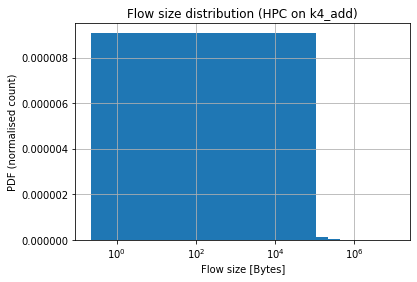

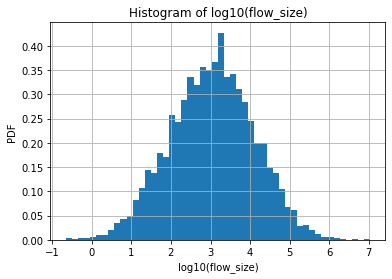

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 1) flow size 배열로 꺼내기
flow_sizes = np.array(demand_data['flow_size'])

print("flow_size 예시:", flow_sizes[:10])

# 2) 히스토그램 (log-x 로 보면 tail 보기 좋음)
plt.figure()
plt.hist(flow_sizes, bins=100, density=True)
plt.xscale('log')
plt.xlabel('Flow size [Bytes]')
plt.ylabel('PDF (normalised count)')
plt.title('Flow size distribution (HPC on k4_add)')
plt.grid(True, which='both', axis='both')
plt.show()


log_fs = np.log10(flow_sizes)   # 또는 np.log

plt.figure()
plt.hist(log_fs, bins=50, density=True)
plt.xlabel('log10(flow_size)')
plt.ylabel('PDF')
plt.title('Histogram of log10(flow_size)')
plt.grid(True)
plt.show()

inter-arrival 예시: [4.34504992 1.15967408 0.20685816 0.46525944 4.46109772 0.24457887
 0.07233225 0.29833745 1.28552571 0.82832971]


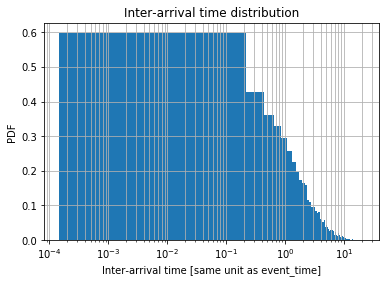

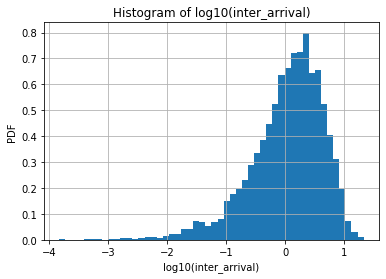

In [10]:
# 1) event_time 정렬
event_times = np.array(demand_data['event_time'])
event_times_sorted = np.sort(event_times)

# 2) 인접 차이 = inter-arrival
inter_arrivals = np.diff(event_times_sorted)

print("inter-arrival 예시:", inter_arrivals[:10])

# 3) 히스토그램
plt.figure()
plt.hist(inter_arrivals, bins=100, density=True)
plt.xscale('log')   # 스케일이 넓을 수 있어서 log-x 추천
plt.xlabel('Inter-arrival time [same unit as event_time]')
plt.ylabel('PDF')
plt.title('Inter-arrival time distribution')
plt.grid(True, which='both', axis='both')
plt.show()


log_ia = np.log10(inter_arrivals)   # 또는 np.log

plt.figure()
plt.hist(log_ia, bins=50, density=True)
plt.xlabel('log10(inter_arrival)')
plt.ylabel('PDF')
plt.title('Histogram of log10(inter_arrival)')
plt.grid(True)
plt.show()

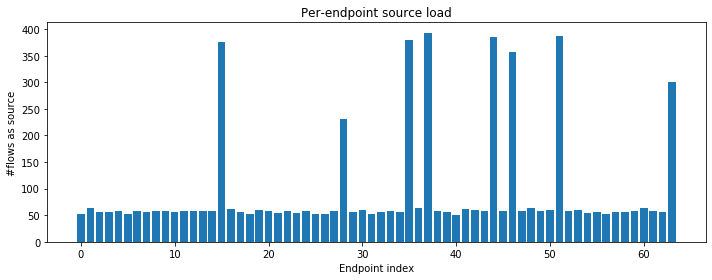

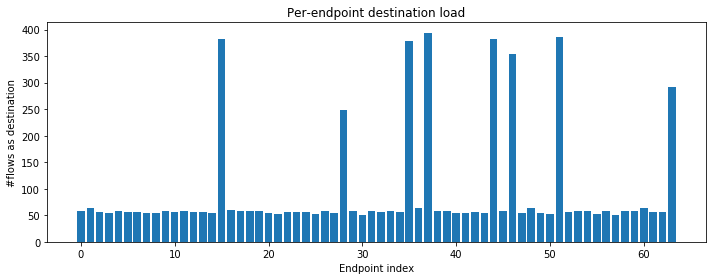

In [11]:
srcs = np.array(demand_data['sn'])
dsts = np.array(demand_data['dn'])

unique_eps = sorted(set(srcs) | set(dsts))
idx = {ep: i for i, ep in enumerate(unique_eps)}
n = len(unique_eps)

src_load = np.zeros(n)
dst_load = np.zeros(n)

for s in srcs:
    src_load[idx[s]] += 1
for d in dsts:
    dst_load[idx[d]] += 1

# 소스 부하
plt.figure(figsize=(10,4))
plt.bar(range(n), src_load)
plt.xlabel('Endpoint index')
plt.ylabel('#flows as source')
plt.title('Per-endpoint source load')
plt.tight_layout()
plt.show()

# 목적지 부하
plt.figure(figsize=(10,4))
plt.bar(range(n), dst_load)
plt.xlabel('Endpoint index')
plt.ylabel('#flows as destination')
plt.title('Per-endpoint destination load')
plt.tight_layout()
plt.show()

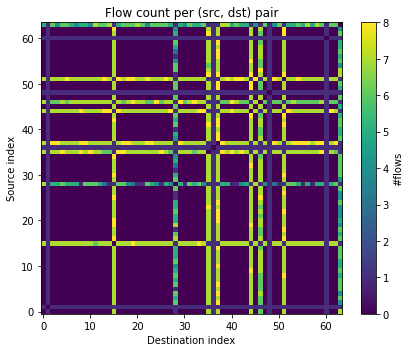

In [12]:
pair_matrix = np.zeros((n, n))

for s, d in zip(srcs, dsts):
    i = idx[s]
    j = idx[d]
    pair_matrix[i, j] += 1

plt.figure(figsize=(6,5))
plt.imshow(pair_matrix, origin='lower', aspect='auto')
plt.colorbar(label='#flows')
plt.xlabel('Destination index')
plt.ylabel('Source index')
plt.title('Flow count per (src, dst) pair')
plt.tight_layout()
plt.show()

In [13]:
print("flow_size min / mean / max:",
      flow_sizes.min(), flow_sizes.mean(), flow_sizes.max())


flow_size min / mean / max: 0.21927076524754938 17355.494795165985 10714604.22022511


In [14]:
print("IA min / mean / max:",
      inter_arrivals.min(), inter_arrivals.mean(), inter_arrivals.max())


IA min / mean / max: 0.00014749128968105651 2.1697984824761565 21.503238252063966


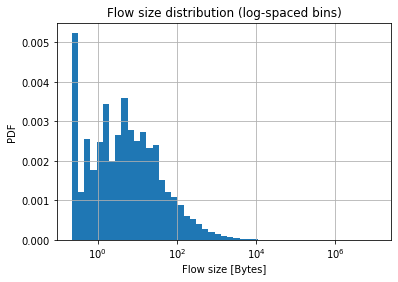

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# log-space bin 경계 만들기
bins = np.logspace(np.log10(flow_sizes.min()),
                   np.log10(flow_sizes.max()),
                   50)   # bin 개수는 취향

plt.figure()
plt.hist(flow_sizes, bins=bins, density=True)
plt.xscale('log')
plt.xlabel('Flow size [Bytes]')
plt.ylabel('PDF')
plt.title('Flow size distribution (log-spaced bins)')
plt.grid(True, which='both', axis='both')
plt.show()
